In [ ]:
!git clone https://github.com/leeyeehoo/CSRNet-pytorch.git

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 86, done.
remote: Total 86 (delta 0), reused 0 (delta 0), pack-reused 86
Unpacking objects: 100% (86/86), done.


In [ ]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
%matplotlib inline

In [ ]:
import scipy.spatial
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [ ]:
#setting the root to the Shanghai dataset you have downloaded
# change the root path as per your location of dataset
root = '/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/'

In [ ]:

part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_train,part_A_test]

In [ ]:
path_sets

['/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images',
 '/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/test_data/images']

In [ ]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [ ]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_1.jpg
(768, 1024)
generate density...
done.
/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_10.jpg
(683, 1024)
generate density...
done.
/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_100.jpg
(654, 1024)
generate density...
done.
/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_101.jpg
(768, 1024)
generate density...
done.
/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_102.jpg
(768, 1024)
generate density...
done.
/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_103.jpg
(400, 400)
generate density...
done.
/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_104.jpg
(405, 540)
generate density...
done.
/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/train_data/images/IMG_105.jpg
(632, 990)
generate density...
done.
/content/drive

KeyboardInterrupt: ignored

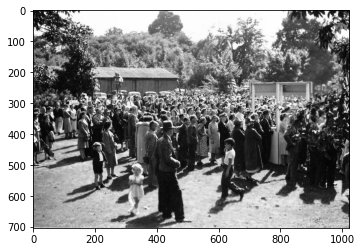

In [ ]:
plt.imshow(Image.open(img_paths[0]))

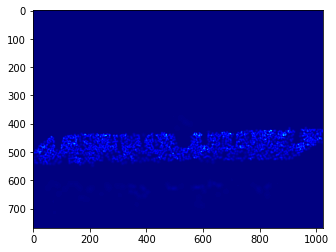

In [ ]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [ ]:
np.sum(groundtruth)

1543.841

In [ ]:
path_sets = [part_B_train,part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
        
# creating density map for part_b images

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

In [ ]:
#importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [ ]:
#defining the location of dataset
root = '/content/drive/MyDrive/org-figure/'
#root = '/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/'
#part_A_train = os.path.join(root,'part_A/train_data','images')
#part_A_test = os.path.join(root,'part_A/test_data','images')
#part_B_train = os.path.join(root,'part_B/train_data','images')
#part_B_test = os.path.join(root,'part_B/test_data','images')
test_fig = os.path.join(root, 'images')
path_sets = [test_fig]
#path_sets = [part_A_test]

In [ ]:
#defining the image path
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
       img_paths.append(img_path)

In [ ]:
glob.glob(os.path.join(path, '*.jpg'))

['/content/drive/MyDrive/org-figure/images/frame-012.jpg',
 '/content/drive/MyDrive/org-figure/images/frame-050.jpg',
 '/content/drive/MyDrive/org-figure/images/frame-041.jpg']

In [ ]:
print(len(img_paths))

3


In [ ]:
model = CSRNet()

In [ ]:
#defining the model
model = model.cuda()

In [ ]:
#loading the trained weights
checkpoint = torch.load('/content/drive/MyDrive/ShanghaiTech/0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    print(mat["image_info"])
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    print(gt)
    print(gt.shape)
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

/content/drive/MyDrive/ShanghaiTech/ShanghaiTech/part_A/test_data/images/IMG_1.jpg
[[array([[(array([[163.48483516, 341.77022977],
       [211.56475524, 442.02197802],
       [333.29902098, 517.72227772],
       [436.6197003 , 372.45954046],
       [391.60871129, 374.50549451],
       [ 45.58673327, 346.37362637],
       [ 11.317003  , 344.32767233],
       [ 15.40891109, 325.4025974 ],
       [ 17.96635365, 284.48351648],
       [ 45.58673327, 288.57542458],
       [ 35.86845155, 320.28771229],
       [ 55.8165035 , 320.7992008 ],
       [ 80.36795205, 307.5004995 ],
       [ 60.93138861, 289.08691309],
       [ 77.29902098, 286.01798202],
       [106.96535465, 312.1038961 ],
       [113.61470529, 297.78221778],
       [127.93638362, 314.14985015],
       [117.19512488, 286.52947053],
       [136.1201998 , 286.01798202],
       [167.320999  , 321.82217782],
       [157.09122877, 304.43156843],
       [186.24607393, 300.85114885],
       [189.82649351, 322.33366633],
       [214.377942

In [ ]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('frame-','GT-frame-'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["M"][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k
    

/content/drive/MyDrive/org-figure/images/frame-012.jpg
(1080, 1920)
generate density...
done.
/content/drive/MyDrive/org-figure/images/frame-050.jpg
(720, 1280)
generate density...
done.
/content/drive/MyDrive/org-figure/images/frame-041.jpg
(400, 304)
generate density...
done.


In [ ]:
from tqdm import tqdm
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground-truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print("\n")
print (mae/len(img_paths))

100%|██████████| 3/3 [00:01<00:00,  2.35it/s]



410.91578674316406


#On single image

Predicted Count :  157


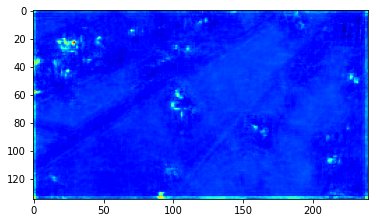

Original Count :  803


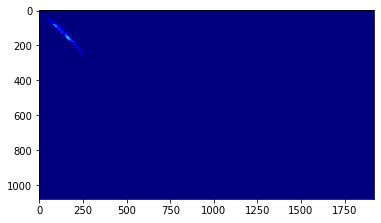

Original Image


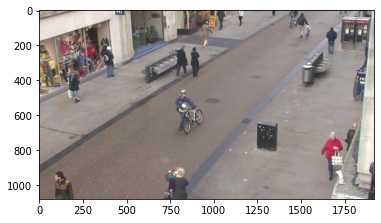

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/drive/MyDrive/org-figure/images/frame-012.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/org-figure/ground-truth/frame-012.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/org-figure/images/frame-012.jpg'))
plt.show()

Predicted Count :  18


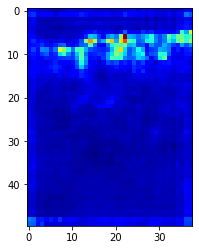

Original Count :  104


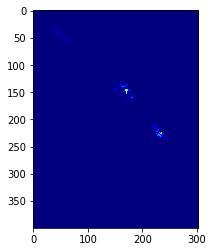

Original Image


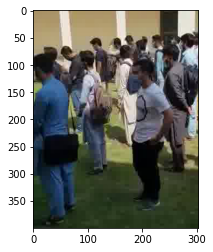

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/drive/MyDrive/org-figure/images/frame-041.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/org-figure/ground-truth/frame-041.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/org-figure/images/frame-041.jpg'))
plt.show()

Predicted Count :  59


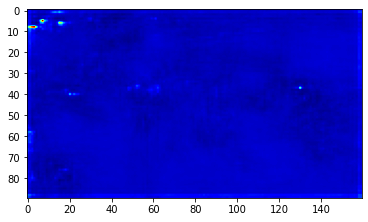

Original Count :  563


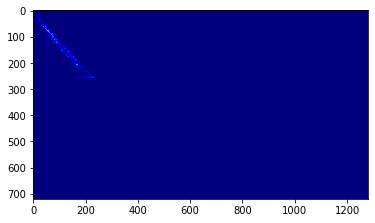

Original Image


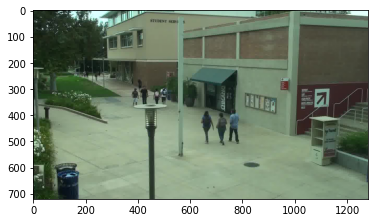

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/drive/MyDrive/org-figure/images/frame-050.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/org-figure/ground-truth/frame-050.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/org-figure/images/frame-050.jpg'))
plt.show()

# Measuring social distancing

In [ ]:
!git clone https://github.com/sherwyn11/Social-Distancing-Analyzer

Cloning into 'Social-Distancing-Analyzer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 66 (delta 22), reused 18 (delta 8), pack-reused 23
Unpacking objects: 100% (66/66), done.


In [ ]:
%cd /content/Social-Distancing-Analyzer

/content/Social-Distancing-Analyzer


In [ ]:
%ls

constants.py  main.py  __pycache__/  requirements.txt  yolov3/
LICENSE       output/  README.md     videos/


In [ ]:
!pip install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/b7/ce/d0b92f0283faa4da76ea82587ff9da70104e81f59ba14f76c87e4196254e/numpy-1.18.2-cp37-cp37m-manylinux1_x86_64.whl
     |████████████████████████████████| 50.4MB 86kB/s 
  Created wheel for imutils: filename=imutils-0.5.3-cp37-none-any.whl size=25850 sha256=1ceb074645bec167bda0bcb8b98e4d61489246f8538795de04d295ad66d95b37
  Stored in directory: /root/.cache/pip/wheels/16/84/1f/bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: openc

In [ ]:
!python main.py

Loading YOLO from disk...
Total frames detected are:  584
Single frame took 1.6314 seconds
Estimated total time to finish: 952.7548 seconds
Cleaning up...
